In [15]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import os
os.chdir(os.path.expanduser('~/wcEcoli'))
import numpy as np
import pandas as pd
from wholecell.utils.filepath import ROOT_PATH
import pickle
import os
from matplotlib import pyplot as plt
os.chdir(os.path.expanduser('~/wcEcoli/'))
# noinspection PyUnresolvedReferences
from wholecell.io.tablereader import TableReader
import io
from wholecell.io import tsv
from wholecell.utils.filepath import ROOT_PATH
import plotly.graph_objects as go
from models.ecoli.analysis import cohortAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader
from sklearn.metrics import r2_score
import seaborn as sns
import glob
import plotly.express as px

In [16]:
# function to match gene symbols to monomer ids
def get_gene_symbols_for_monomer_ids():
	"""
	Extracts the gene symbols for each monomer id in the model.
	Returns: a dictionary mapping monomer ids to gene symbols.
	Code adapted from convert_to_flat.py.
	"""
	RNAS_FILE = os.path.join(ROOT_PATH, 'reconstruction', 'ecoli',
								 'flat', 'rnas.tsv')
	with (io.open(RNAS_FILE, 'rb') as f):
		reader = tsv.reader(f, delimiter='\t')
		headers = next(reader)
		while headers[0].startswith('#'):
			headers = next(reader)

		# extract relevant information
		gene_symbol_index = headers.index('common_name')
		protein_id_index = headers.index('monomer_ids')
		monomer_ids_to_gene_symbols = {}
		for line in reader:
			gene_symbol = line[gene_symbol_index]
			protein_id = list(
				line[protein_id_index][2:-2].split('", "'))[0]
			monomer_ids_to_gene_symbols[protein_id] = gene_symbol

	return monomer_ids_to_gene_symbols

def get_common_name(protein_id):
    """
    Get the common name of a protein given its monomer id.
    Args:
        protein_id: the name of the monomer

    Returns:
        common_name: The common name of the protein.

    """
    # remove the compartment tag first if it exists:
    if '[' in protein_id:
        protein_id = protein_id[:-3]  # subtract the compartment
        common_name = get_gene_symbols_for_monomer_ids()[protein_id]
    else:
        common_name = get_gene_symbols_for_monomer_ids()[protein_id]
    return common_name

In [25]:
# generate a dataframe with relevant information:
# Name the sequences to use:
current_sequence = "Clim4_annotated"
CLNE_sequence = "CLNE3"
branch_name = "pd-half-life-debug"


# read in the CLClim3NE (2025 model) half life data:
CLClim3NE1_HLs = f"out/{current_sequence}/kb_plot_out/protein_half_lives.tsv"
CLClim3NE1_HLs = pd.read_csv(CLClim3NE1_HLs, sep='\t')
CLClim3NE1_HLs = CLClim3NE1_HLs.rename(columns={"monomer_id": "id"})

# add the common names to the dataframe:
CLClim3NE1_HLs['common_name'] = None
for index, row in CLClim3NE1_HLs.iterrows():
    common_name = get_common_name(row['id'])
    CLClim3NE1_HLs.at[index, 'common_name'] = common_name


priority_substrates = "reconstruction/ecoli/flat/priority_protease_assignments_0.tsv"
priority_substrates = pd.read_csv(priority_substrates, sep='\t', skiprows=1)

    
CLClim3NE1_HLs['protease_assignment'] = None
CLClim3NE1_HLs['ClpP'] = None
CLClim3NE1_HLs['Lon'] = None
CLClim3NE1_HLs['HslV'] = None
CLClim3NE1_HLs['Unexplained'] = None
for index, row in CLClim3NE1_HLs.iterrows():
    if row['id'] in priority_substrates['id'].values:
        CLClim3NE1_HLs.at[index, 'protease_assignment'] = priority_substrates[priority_substrates['id'] == row['id']]['protease_assignment'].values[0]
        CLClim3NE1_HLs.at[index, 'ClpP'] = priority_substrates[priority_substrates['id'] == row['id']]['ClpP'].values[0]
        CLClim3NE1_HLs.at[index, 'Lon'] = priority_substrates[priority_substrates['id'] == row['id']]['Lon'].values[0]
        CLClim3NE1_HLs.at[index, 'HslV'] = priority_substrates[priority_substrates['id'] == row['id']]['HslV'].values[0]
        CLClim3NE1_HLs.at[index, 'Unexplained'] = priority_substrates[priority_substrates['id'] == row['id']]['Unexplained'].values[0]
    
# 
# add complex names to the HL_data
complex_table = "out/complex_classification_tables/all_monomers_sorted.csv"
complex_table = pd.read_csv(complex_table)
complex_names_dict = {}
for index, row in complex_table.iterrows():
    complex_names_dict[row["monomer_id"]] = row["complex_id"]
CLClim3NE1_HLs["complex_id"] = CLClim3NE1_HLs["id"].map(complex_names_dict)

# replace all NaN values with "None"
CLClim3NE1_HLs["complex_id"] = CLClim3NE1_HLs["complex_id"].fillna("None")
# for index, row in CLClim3NE1_HLs.iterrows():
#     if row["complex_id"] == "None":
#         CLClim3NE1_HLs.at[index, "protease_assignment_complex"] = row["protease_assignment"] + " (monomer)"
#     else:
#         CLClim3NE1_HLs.at[index, "protease_assignment_complex"] = row["protease_assignment"] + " (complex)"
for index, row in CLClim3NE1_HLs.iterrows():
    protease_assignment = row["protease_assignment"]
    
    if pd.isna(protease_assignment):  # Check if protease_assignment is NaN
        protease_assignment = "Unknown"  # Assign a placeholder if needed, or just skip

    if row["complex_id"] == "None":
        CLClim3NE1_HLs.at[index, "protease_assignment_complex"] = protease_assignment + " (monomer)"
    else:
        CLClim3NE1_HLs.at[index, "protease_assignment_complex"] = protease_assignment + " (complex)"


CLClim3NE1_HLs


,id,degradation_rate(1/s),half_life_(min),degradation_rate_source,common_name,protease_assignment,ClpP,Lon,HslV,Unexplained,complex_id,protease_assignment_complex
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,1.925409e-05,600.000000,N_end_rule,plsC,None,None,None,None,None,None,Unknown (monomer)
1,1-PFK-MONOMER,7.507388e-07,15388.112655,Gupta_et_al_MS_2024,fruK,None,None,None,None,None,1-PFK,Unknown (complex)
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,2.669108e-05,432.820802,Gupta_et_al_MS_2024,panE,None,None,None,None,None,None,Unknown (monomer)
3,2-ISOPROPYLMALATESYN-MONOMER,2.117631e-05,545.536619,Gupta_et_al_MS_2024,leuA,None,None,None,None,None,None,Unknown (monomer)
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,8.600331e-06,1343.256864,Gupta_et_al_MS_2024,ubiE,None,None,None,None,None,CPLX0-8301,Unknown (complex)
...,...,...,...,...,...,...,...,...,...,...,...,...
4304,YTFR-MONOMER,4.265786e-06,2708.165245,Gupta_et_al_MS_2024,ytfR,None,None,None,None,None,ABC-46-CPLX,Unknown (complex)
4305,YTFT-MONOMER,5.544879e-06,2083.445324,Gupta_et_al_MS_2024,ytfT,None,None,None,None,None,ABC-46-CPLX,Unknown (complex)
4306,ZNUA-MONOMER,5.192109e-06,2225.002167,Gupta_et_al_MS_2024,znuA,None,None,None,None,None,ABC-63-CPLX,Unknown (complex)
4307,ZNUB-MONOMER,1.925409e-05,600.000000,N_end_rule,znuB,None,None,None,None,None,ABC-63-CPLX,Unknown (complex)


In [26]:
HL_data = CLClim3NE1_HLs.copy()

In [19]:
# # load in the data:
# HL_data = "models/ecoli/analysis/local_notebooks/venn_diagram/data/merged_data.csv"
# HL_data = pd.read_csv(HL_data)
# 
# # read in the other data to get the common names:
# common_names = "reconstruction/ecoli/scripts/protein_half_lives/Gupta_et_al_Clim_data/Clim_EcoCyc_monomer_ID_matches/41467_2024_49920_MOESM4_ESM_ST1_EcoCyc_monomer_ID_matches_11202024.tsv"
# common_names = pd.read_csv(common_names, sep="\t", header=1)
# 
# # go through each id in the HL_data and get the "Common Name" that corresponds to the "Monomer ID"
# common_names_dict = {}
# for index, row in common_names.iterrows():
#     common_names_dict[row["Monomer ID"]] = row["Common Name"]
# 
# # add the common names to the HL_data
# HL_data["common_name"] = HL_data["id"].map(common_names_dict)
# 
# # add complex names to the HL_data
# complex_table = "out/complex_classification_tables/all_monomers_sorted.csv"
# complex_table = pd.read_csv(complex_table)
# complex_names_dict = {}
# for index, row in complex_table.iterrows():
#     complex_names_dict[row["monomer_id"]] = row["complex_id"]
# HL_data["complex_id"] = HL_data["id"].map(complex_names_dict)
# 
# # replace all NaN values with "None"
# HL_data["complex_id"] = HL_data["complex_id"].fillna("None")
# for index, row in HL_data.iterrows():
#     if row["complex_id"] == "None":
#         HL_data.at[index, "protease_assignment_complex"] = row["protease_assignment"] + " (monomer)"
#     else:
#         HL_data.at[index, "protease_assignment_complex"] = row["protease_assignment"] + " (complex)"
# 
# 
# HL_data

In [27]:
# count the number of different assignements in the protease_assignment column and how many times they appear
counts = HL_data['protease_assignment'].value_counts()
counts = counts.to_dict()
counts

{'ClpP only': 40,
 'Additive: ClpP, Lon, HslV': 32,
 'Lon only': 6,
 'Additive: ClpP, Lon': 3,
 'HslV only': 1}

# Donut plot

Code adapted from: https://python-graph-gallery.com/donut-plot/

Pros: easy to see

Cons: cannot put the #s on the chart itself, which might be nice (could just add it as brackets tho

Future things to explore: maybe split up more, into having a each pie slice have a lighter shade in it to represent monomers vs the darker shade representing complexes.

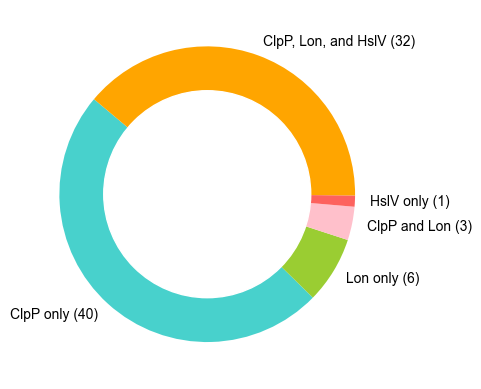

In [21]:
# library
import matplotlib.pyplot as plt

# create data
size_of_groups=[40, 6, 3, 1, 32]
# create data
names = ['ClpP only (40)', 'Lon only (6)', 'ClpP and Lon (3)', 'HslV only (1)', 'ClpP, Lon, and HslV (32)']
colors = ['mediumturquoise','yellowgreen','pink','#fd625e', 'orange']
# Create a pieplot
plt.pie(size_of_groups, labels=names, colors=colors, startangle=140,  )

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')

p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()


# priority substrate data plots

# prep data

In [22]:
current_sequence = "Clim4_annotated"
CLNE_sequence = "CLNE_11192024"

In [38]:
# read in the unfiltered data:
CLClimNE_log_data_with_proteases1 = pd.read_csv(f'out/{current_sequence}/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')

# remove the last three characters from each entry in the Monomer ID column:
CLClimNE_log_data_with_proteases1['Monomer ID'] = CLClimNE_log_data_with_proteases1['Monomer ID'].str[:-3]


# merge this data with the HL_data to get the protease assignments:
# merge the HL_data with the CLClimNE_log_data_with_proteases on the Monomer ID and id columns:
HL_data = HL_data.rename(columns={"id": "Monomer ID"})
HL_data = HL_data.rename(columns={"protease_assignment": "protease assignment"})
# cahnge common name to gene symbol
HL_data = HL_data.rename(columns={"common_name": "gene symbol"})
# rename half_life_(min) to HL value
HL_data = HL_data.rename(columns={"half_life_(min)": "HL value"})
# rename source to HL source
HL_data = HL_data.rename(columns={"degradation_rate_source": "HL source"})
# merge the CLClimNE_log_data_with_proteases into the HL_data
CLClimNE_log_data_with_proteases = HL_data.merge(CLClimNE_log_data_with_proteases1[['Monomer ID', 'Log10 Average Monomer Counts' ]], on='Monomer ID', how='left')


CLClimNE_log_data_with_proteases

,Monomer ID,degradation_rate(1/s),HL value,HL source,gene symbol,protease assignment,ClpP,Lon,HslV,Unexplained,complex_id,protease_assignment_complex,Log10 Average Monomer Counts
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,1.925409e-05,600.000000,N_end_rule,plsC,None,None,None,None,None,None,Unknown (monomer),2.170663
1,1-PFK-MONOMER,7.507388e-07,15388.112655,Gupta_et_al_MS_2024,fruK,None,None,None,None,None,1-PFK,Unknown (complex),2.516061
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,2.669108e-05,432.820802,Gupta_et_al_MS_2024,panE,None,None,None,None,None,None,Unknown (monomer),2.336496
3,2-ISOPROPYLMALATESYN-MONOMER,2.117631e-05,545.536619,Gupta_et_al_MS_2024,leuA,None,None,None,None,None,None,Unknown (monomer),3.587158
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,8.600331e-06,1343.256864,Gupta_et_al_MS_2024,ubiE,None,None,None,None,None,CPLX0-8301,Unknown (complex),2.215084
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4304,YTFR-MONOMER,4.265786e-06,2708.165245,Gupta_et_al_MS_2024,ytfR,None,None,None,None,None,ABC-46-CPLX,Unknown (complex),0.778151
4305,YTFT-MONOMER,5.544879e-06,2083.445324,Gupta_et_al_MS_2024,ytfT,None,None,None,None,None,ABC-46-CPLX,Unknown (complex),0.954243
4306,ZNUA-MONOMER,5.192109e-06,2225.002167,Gupta_et_al_MS_2024,znuA,None,None,None,None,None,ABC-63-CPLX,Unknown (complex),2.988847
4307,ZNUB-MONOMER,1.925409e-05,600.000000,N_end_rule,znuB,None,None,None,None,None,ABC-63-CPLX,Unknown (complex),1.684500


In [39]:
# figure out which proteins were assigned to lon in the model:
lon_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'Lon only']
lon_proteins

# figure out which proteins were assigned to clp in the model:
clp_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'ClpP only']

hslv_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'HslV only']

# figure out which proteins are additive in the model:
additive_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'Additive: ClpP, Lon']

# figure out which proteins are redundant in the model:
redundant_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'Additive: ClpP, Lon, HslV']



# figure out which proteins were not assigned to a protease in the model:
no_protease_proteins = CLClimNE_log_data_with_proteases[CLClimNE_log_data_with_proteases['protease assignment'] == 'NA']

# todo: note that these numbers will not add up to those in the graph below bc some proteins in the CLClim0NE model are not in the CLNE model
#298 total
print("Lon Proteins(" +str(len(lon_proteins))+"): ", list(lon_proteins['gene symbol'])) #14
print("ClpP Proteins(" +str(len(clp_proteins))+"): ", list(clp_proteins['gene symbol'])) #63
print("HslV Proteins(" +str(len(hslv_proteins))+"): ", list(hslv_proteins['gene symbol'])) #1
print("Additive Proteins: Lon, ClpP (" +str(len(additive_proteins))+"): ", list(additive_proteins['gene symbol'])) #79
print("Additive: Lon, ClpP, HslV Proteins(" +str(len(redundant_proteins))+"): ", list(redundant_proteins['gene symbol'])) #39
#print("No Protease Proteins(" +str(len(no_protease_proteins))+"): ", list(no_protease_proteins['gene symbol'])) # 4012

# ClpP does not have

Lon Proteins(6):  ['ydcI', 'nemA', 'fhlA', 'metR', 'trxC', 'rpoD']
ClpP Proteins(40):  ['fadE', 'glpD', 'cysD', 'ribB', 'clpA', 'clpX', 'dksA', 'dnaB', 'dnaK', 'ftsZ', 'mukB', 'mutS', 'nfo', 'parC', 'pcnB', 'recA', 'rpsA', 'sbcC', 'uvrD', 'dps', 'def', 'phoH', 'intA', 'rutA', 'comR', 'ydhQ', 'yfcZ', 'patA', 'obgE', 'yheO', 'lldD', 'mdlB', 'oxyR', 'exuR', 'putA', 'rpoB', 'rpoC', 'rpoS', 'yheS', 'znuC']
HslV Proteins(1):  ['uhpA']
Additive Proteins: Lon, ClpP (3):  ['ibpA', 'grcA', 'dnaA']
Additive: Lon, ClpP, HslV Proteins(32):  ['aroK', 'helD', 'ligA', 'minE', 'parE', 'pspA', 'rhlB', 'srmB', 'ybaB', 'yibA', 'mazF', 'yjgA', 'yihD', 'yiiQ', 'yiaU', 'yfhH', 'erpA', 'ppiC', 'glaR', 'chaB', 'rarA', 'proQ', 'acpP', 'ycaR', 'hprR', 'murQ', 'iscR', 'kbp', 'yggX', 'glnD', 'yaeP', 'thiL']


In [40]:
# prepare the data for a plot:
CLClimNE_log_data_with_proteases = CLClimNE_log_data_with_proteases.copy()

CLNE_log_data = pd.read_csv('/Users/miagrahn/wcEcoli/out/CLNE_11192024/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLNE_log_data['Monomer ID'] = CLNE_log_data['Monomer ID'].str[:-3]

# merge the two dataframes:
CLNE_new_name = "Log10 " +CLNE_sequence +" Average Monomer Counts"
CLClimNE_new_name = "Log10 " +current_sequence +" Average Monomer Counts"

CLNE_log_data = CLNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLNE_new_name})
CLClimNE_log_data_with_proteases = CLClimNE_log_data_with_proteases.rename(columns={"Log10 Average Monomer Counts": CLClimNE_new_name})
#CLNE_log_data = CLNE_log_data[["Monomer ID", "Log10 CLNE Protein Counts"]]
#CLClimNE_log_data_with_proteases = CLClimNE_log_data_with_proteases[["Monomer ID", "Log10 CLClim0NE Protein Counts"]]
CLNE_log_data = CLNE_log_data.set_index("Monomer ID")
CLClimNE_log_data_with_proteases = CLClimNE_log_data_with_proteases.set_index("Monomer ID")
CLNE_CLClimNE_log_data_proteases = CLNE_log_data.join(CLClimNE_log_data_with_proteases, how="inner")
CLNE_CLClimNE_log_data_proteases = CLNE_CLClimNE_log_data_proteases.reset_index()

# make a copy of the CLClimNE_log_data_with_proteases data:
CLClimNE_log_data_with_Lon_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Clp_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_HslV_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Additive_LC = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Additive_LCH = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_no_protease_proteases = CLNE_CLClimNE_log_data_proteases.copy()

# remove the proteins that were not assigned to the protease in the model:
CLClimNE_log_data_with_Lon_proteases = CLClimNE_log_data_with_Lon_proteases[CLClimNE_log_data_with_Lon_proteases['protease assignment'] == 'Lon only']
CLClimNE_log_data_with_Clp_proteases = CLClimNE_log_data_with_Clp_proteases[CLClimNE_log_data_with_Clp_proteases['protease assignment'] == 'ClpP only']
CLClimNE_log_data_with_HslV_proteases = CLClimNE_log_data_with_HslV_proteases[CLClimNE_log_data_with_HslV_proteases['protease assignment'] == 'HslV only']
CLClimNE_log_data_with_Additive_LC_proteases = CLClimNE_log_data_with_Additive_LC[CLClimNE_log_data_with_Additive_LC['protease assignment'] == 'Additive: ClpP, Lon']
CLClimNE_log_data_with_Additive_LCH_proteases = CLClimNE_log_data_with_Additive_LCH[CLClimNE_log_data_with_Additive_LCH['protease assignment'] == 'Additive: ClpP, Lon, HslV']
CLClimNE_log_data_with_no_protease_proteases = CLClimNE_log_data_with_no_protease_proteases[CLClimNE_log_data_with_no_protease_proteases['protease assignment'] == 'NA']


also tag proteins by their degredation rate:

In [41]:
# todo: should I calculate the log2 fold change?

# calculate the fold change between the log counts of CLNE and CLClim3NE:
CLNE_CLClimNE_log_data_proteases['protein_fold_change'] = 10**(CLNE_CLClimNE_log_data_proteases[CLClimNE_new_name]) / 10**(CLNE_CLClimNE_log_data_proteases[CLNE_new_name])
# calculate the log2 fold change between the log counts of CLNE and CLClim3NE:
CLNE_CLClimNE_log_data_proteases['log2_fold_change'] = np.log2(CLNE_CLClimNE_log_data_proteases['protein_fold_change'])
# calculate the log10 fold change between the log counts of CLNE and CLClim3NE:
CLNE_CLClimNE_log_data_proteases['log10_fold_change'] = np.log10(CLNE_CLClimNE_log_data_proteases['protein_fold_change'])

# find the proteins that had a difference of less than -400:
largest_change = CLNE_CLClimNE_log_data_proteases[(CLNE_CLClimNE_log_data_proteases['HL value'] < 50) & (CLNE_CLClimNE_log_data_proteases['HL source'] == 'Gupta_et_al_MS_2024')]


largest_change = largest_change.sort_values(by="HL value", ascending=True) # I think it is already sorted by difference
largest_change

,Monomer ID,Log10 CLNE3 Average Monomer Counts,degradation_rate(1/s),HL value,HL source,gene symbol,protease assignment,ClpP,Lon,HslV,Unexplained,complex_id,protease_assignment_complex,Log10 Clim4_annotated Average Monomer Counts,protein_fold_change,log2_fold_change,log10_fold_change
3862,PD03867,1.731011,0.016234,0.711614,Gupta_et_al_MS_2024,rbsR,None,None,None,None,None,None,Unknown (monomer),0.000000,0.018578,-5.750295,-1.731011
1649,EG50004-MONOMER,4.419169,0.003115,3.708858,Gupta_et_al_MS_2024,rmf,None,None,None,None,None,None,Unknown (monomer),3.344475,0.084199,-3.570057,-1.074694
3078,G7872-MONOMER,2.148717,0.002142,5.393915,Gupta_et_al_MS_2024,ytfK,None,None,None,None,None,None,Unknown (monomer),1.181621,0.107871,-3.212626,-0.967097
1094,EG11605-MONOMER,1.891716,0.001965,5.878963,Gupta_et_al_MS_2024,smg,None,None,None,None,None,None,Unknown (monomer),0.940076,0.111779,-3.161277,-0.951639
48,ADHP-MONOMER,2.662772,0.001723,6.706487,Gupta_et_al_MS_2024,adhP,None,None,None,None,None,CPLX0-8015,Unknown (complex),2.396199,0.541287,-0.885534,-0.266572
3441,MONOMER0-2660,2.035474,0.001153,10.019753,Gupta_et_al_MS_2024,ybdD,None,None,None,None,None,None,Unknown (monomer),1.804518,0.587549,-0.767218,-0.230956
2422,G6988-MONOMER,0.975811,0.000995,11.610089,Gupta_et_al_MS_2024,yeaW,None,None,None,None,None,CPLX0-8232,Unknown (complex),0.000000,0.105728,-3.241573,-0.975811
980,EG11389-MONOMER,3.490012,0.000943,12.249997,Gupta_et_al_MS_2024,fliT,None,None,None,None,None,None,Unknown (monomer),2.701722,0.162821,-2.618642,-0.788290
2865,G7568-MONOMER,2.135373,0.000872,13.242741,Gupta_et_al_MS_2024,ygiQ,None,None,None,None,None,None,Unknown (monomer),1.558958,0.265207,-1.914808,-0.576415
979,EG11388-MONOMER,3.495836,0.000867,13.328801,Gupta_et_al_MS_2024,fliS,None,None,None,None,None,None,Unknown (monomer),2.737103,0.174288,-2.520458,-0.758733


In [42]:
import seaborn as sns
# make a copy of the data:
priority_substrates = CLNE_CLClimNE_log_data_proteases.copy()

# remove the proteins that were not assigned to the protease in the model:
priority_substrates = priority_substrates[priority_substrates['protease assignment'] != 'NA']

priority_substrates





,Monomer ID,Log10 CLNE3 Average Monomer Counts,degradation_rate(1/s),HL value,HL source,gene symbol,protease assignment,ClpP,Lon,HslV,Unexplained,complex_id,protease_assignment_complex,Log10 Clim4_annotated Average Monomer Counts,protein_fold_change,log2_fold_change,log10_fold_change
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,2.248895,1.925409e-05,600.000000,N_end_rule,plsC,None,None,None,None,None,None,Unknown (monomer),2.170663,0.835156,-0.259882,-0.078232
1,1-PFK-MONOMER,1.829031,7.507388e-07,15388.112655,Gupta_et_al_MS_2024,fruK,None,None,None,None,None,1-PFK,Unknown (complex),2.516061,4.864409,2.282264,0.687030
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,2.155309,2.669108e-05,432.820802,Gupta_et_al_MS_2024,panE,None,None,None,None,None,None,Unknown (monomer),2.336496,1.517704,0.601890,0.181187
3,2-ISOPROPYLMALATESYN-MONOMER,3.603593,2.117631e-05,545.536619,Gupta_et_al_MS_2024,leuA,None,None,None,None,None,None,Unknown (monomer),3.587158,0.962864,-0.054596,-0.016435
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,2.619919,8.600331e-06,1343.256864,Gupta_et_al_MS_2024,ubiE,None,None,None,None,None,CPLX0-8301,Unknown (complex),2.215084,0.393699,-1.344835,-0.404836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4304,YTFR-MONOMER,1.591232,4.265786e-06,2708.165245,Gupta_et_al_MS_2024,ytfR,None,None,None,None,None,ABC-46-CPLX,Unknown (complex),0.778151,0.153787,-2.700996,-0.813081
4305,YTFT-MONOMER,1.569764,5.544879e-06,2083.445324,Gupta_et_al_MS_2024,ytfT,None,None,None,None,None,ABC-46-CPLX,Unknown (complex),0.954243,0.242370,-2.044717,-0.615521
4306,ZNUA-MONOMER,2.792515,5.192109e-06,2225.002167,Gupta_et_al_MS_2024,znuA,None,None,None,None,None,ABC-63-CPLX,Unknown (complex),2.988847,1.571561,0.652199,0.196331
4307,ZNUB-MONOMER,1.856827,1.925409e-05,600.000000,N_end_rule,znuB,None,None,None,None,None,ABC-63-CPLX,Unknown (complex),1.684500,0.672470,-0.572458,-0.172327


## half lives

In [43]:
# HL data only:
data_HL = priority_substrates[['gene symbol', 'HL value', 'protease assignment']]
data_HL.set_index('gene symbol', inplace=True)
# sort the data by the HL value:
data_HL = data_HL.sort_values(by='HL value', ascending=True)

data_HL

,HL value,protease assignment
gene symbol,,
rbsR,0.711614,None
rmf,3.708858,None
ytfK,5.393915,None
smg,5.878963,None
adhP,6.706487,None
...,...,...
suhB,213925.231480,None
dapB,230397.464749,None
ihfA,374855.210913,None


Text(152.84722222222223, 0.5, 'Gupta et al. Half Life (min)')

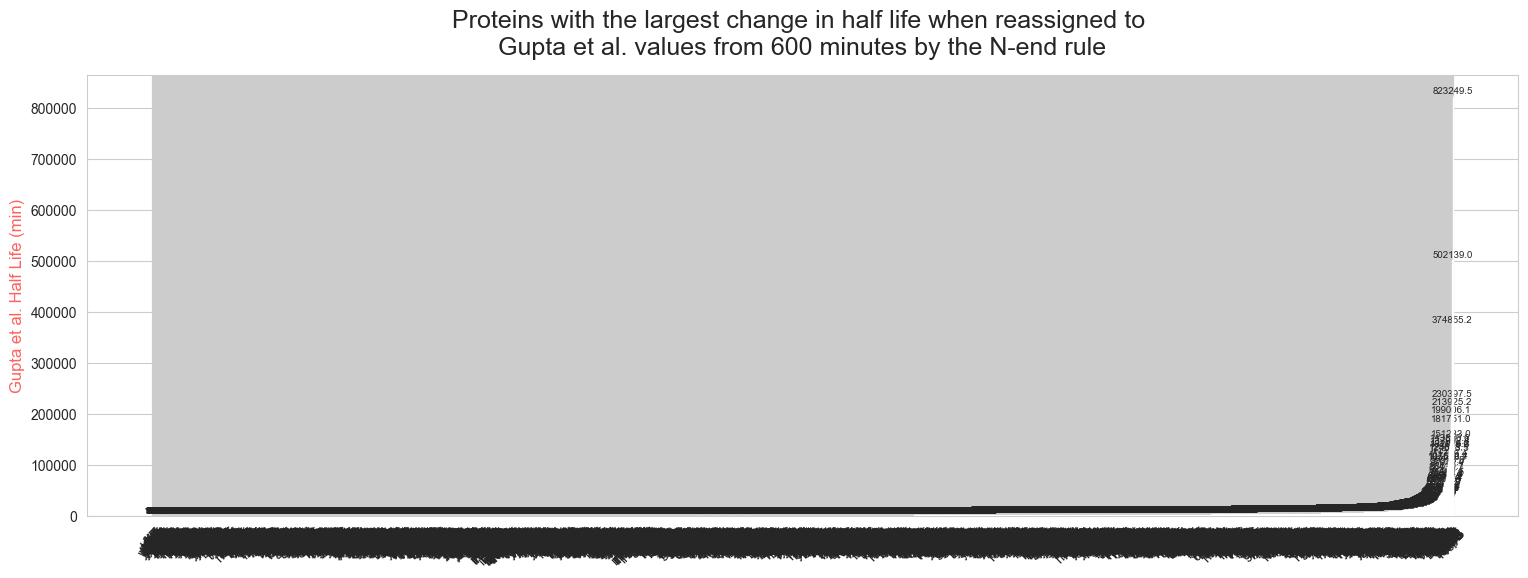

In [44]:
# make a bar plot of the half lives by the common names and color them by protease assignement:


font_color = '#525252'
hfont = {'fontname':'Calibri'}
#facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data_HL.index
column0 = data_HL['HL value']
title0 = 'Proteins with the largest change in half life when reassigned to \nGupta et al. values from 600 minutes by the N-end rule'

fig, axes = plt.subplots(figsize=(15,5),  nrows=1, )
fig.tight_layout()

axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )
for i, val in enumerate(column0):
    axes.text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )

axes.set(xticks=data_HL.index, xticklabels=data_HL.index)
for tick in axes.get_xticklabels():
    tick.set_rotation(45)

axes.set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )

#plt.subplots_adjust(hspace=0, top=1.2, bottom=0, left=0.18, right=0.95)

# # save the figure:
# out_pth = "out/figures/PDR_UPDATE_MERGE/Clim3_related/plots_under_the_donut/plots_under_the_donut_HLs_only.png"
# out_pth = os.path.expanduser(out_pth)
# output_dir = os.path.dirname(out_pth)
# os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
# plt.savefig(out_pth, dpi=300, bbox_inches='tight')

NameError: name 'color_dict' is not defined

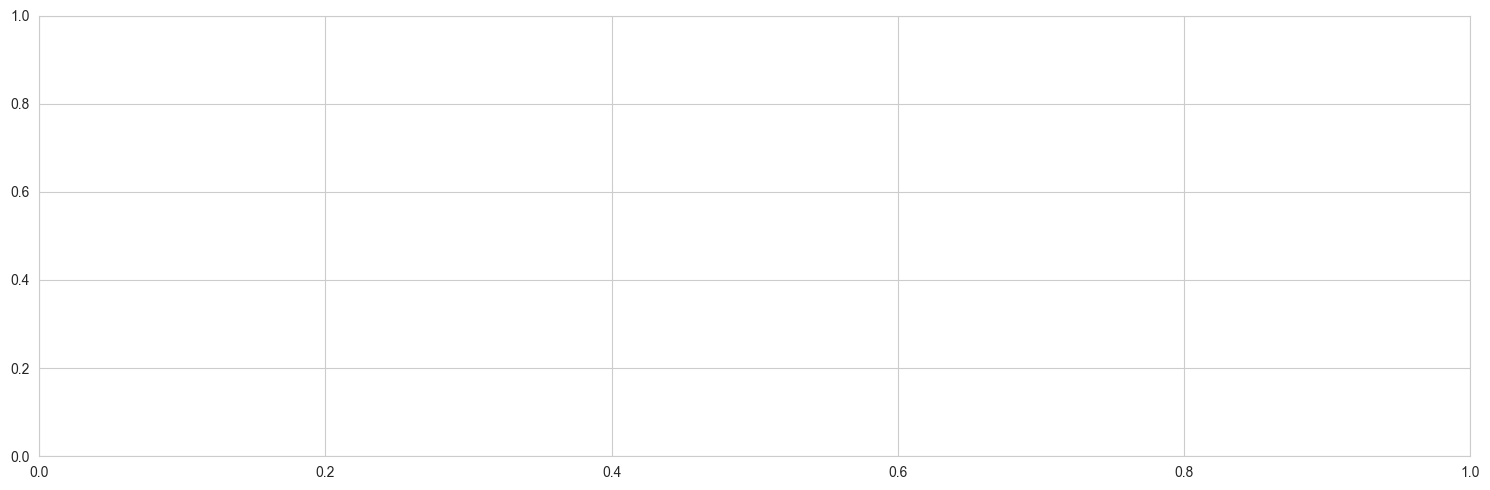

In [45]:
#https://stackoverflow.com/questions/68616781/customizing-the-hue-colors-used-in-seaborn-barplot
#https://stackoverflow.com/questions/72444622/how-to-set-different-colors-on-matplotlib-bar-graph-based-on-the-group-of-data

fig, axes = plt.subplots(figsize=(15,5),  nrows=1, )
fig.tight_layout()


sns.barplot(x='gene symbol', y='HL value', data=data_HL, hue='protease assignment', palette=color_dict, dodge=False, edgecolor='none')
plt.xticks(rotation=45)
plt.title(title0, fontsize=18, pad=15, )
plt.ylabel('Gupta et al. Half Life (min)', fontsize=12, )
plt.xlabel('')
plt.legend(title='Protease Assignment')

# add values to the bars:
#for i, val in enumerate(column0):
    #axes.text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )

# remove the top and right spines:
axes.spines[['right', 'top']].set_visible(False) #https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis


# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/Clim3_related/plots_under_the_donut/plots_under_the_donut_HLs_only.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

 Make the same plot as above but order

In [ ]:
#https://stackoverflow.com/questions/68616781/customizing-the-hue-colors-used-in-seaborn-barplot
#https://stackoverflow.com/questions/72444622/how-to-set-different-colors-on-matplotlib-bar-graph-based-on-the-group-of-data


data_HL_sections = data_HL.sort_values(by=['protease assignment', 'HL value'], ascending=[True, True])
# sort the data within the protease assignment by the HL value:

fig, axes = plt.subplots(figsize=(15,5),  nrows=1, )
fig.tight_layout()


sns.barplot(x='gene symbol', y='HL value', data=data_HL_sections, hue='protease assignment', palette=color_dict, dodge=False, edgecolor='none')
plt.xticks(rotation=45)
plt.title(title0, fontsize=18, pad=15, )
plt.ylabel('Gupta et al. Half Life (min)', fontsize=12, )
plt.xlabel('')
plt.legend(title='Protease Assignment')

# add values to the bars:
#for i, val in enumerate(column0):
    #axes.text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )

# remove the top and right spines:
axes.spines[['right', 'top']].set_visible(False) #https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis


# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/Clim3_related/plots_under_the_donut/plots_under_the_donut_HLs_sorted_by_protease_assginment.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

In [ ]:
# todo: consider adding one that is the new and old average monomer counts together

In [ ]:
#https://stackoverflow.com/questions/68616781/customizing-the-hue-colors-used-in-seaborn-barplot
#https://stackoverflow.com/questions/72444622/how-to-set-different-colors-on-matplotlib-bar-graph-based-on-the-group-of-data

fig, axes = plt.subplots(figsize=(15,5),  nrows=1, )
fig.tight_layout()


sns.barplot(x='gene symbol', y='HL value', data=data_HL, hue='protease assignment', palette=color_dict, dodge=False, edgecolor='none')
plt.xticks(rotation=45)
plt.title(title0, fontsize=18, pad=15, )
plt.ylabel('Gupta et al. Half Life (min)', fontsize=12, )
plt.xlabel('')
plt.legend(title='Protease Assignment')

# add values to the bars:
#for i, val in enumerate(column0):
    #axes.text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )

# remove the top and right spines:
axes.spines[['right', 'top']].set_visible(False) #https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis

# good article: https://stackoverflow.com/questions/42878462/changing-the-color-of-a-single-x-axis-tick-label
for i in range(len(names)):
    name = tick_labels[i].get_text()
    protease_assignment = data_PF.loc[name, 'protease_assignment']
    protease_color = color_dict[protease_assignment]
    plt.setp(axes.get_xticklabels()[i], rotation=45,  color=protease_color)
    
    
# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/Clim3_related/plots_under_the_donut/plots_under_the_donut_HLs_only_names_colored.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')




## protease fraction

In [ ]:
# todo: consider having this be a dual y axis plot..... ahhhhh! where there is a line per type of protease contribution (ie Clp, Lon, HslV, and unexplained) in different colors so we can see the contribution of each? OR have a y axis be fraction of protease contribution unexplained and then have the lower y axis be the contributions from the other sources. have the fraction unexplained be the same color as the key above?

# todo: could also do a fold change graph, with fold change on one side, then the two different protein counts on the other side

# todo: still do a sock plot version of both?

# might be helpful bc there are outlines: https://stackoverflow.com/questions/12862529/alternate-colors-in-stacked-matplotlib-bar

# method 1:
# have the original color coded plot.

# for the compoenent plot, have them in the same order and all the same height, just broken up by different assignment colors


# method 2:
# the HL plot just has outlines of the respective colors and then is a sock plot with the complex fractions within it. kill two birds with one stone

In [ ]:
HL_data

In [ ]:
# HL data only:
data_PF = HL_data[['common_name', 'half_life_(min)', 'protease_assignment', 'ClpP', 'Lon', 'HslV', 'Unexplained']]
data_PF.set_index('common_name', inplace=True)
# sort the data by the HL value:
data_PF = data_PF.sort_values(by='half_life_(min)', ascending=True)


# other data to be used in all plots: 
ClpP = data_PF['ClpP'].values
Lon = data_PF['Lon'].values
HslV = data_PF['HslV'].values
Unexplained = data_PF['Unexplained'].values

# todo: decide how to handle the unexplained data and the redundant/additive data. not sure how to make this look nice. 
compostions1 = {
    'Unexplained': Unexplained,
    'HslV': HslV,
   'Lon': Lon,
    'ClpP': ClpP}

compostions = {
    'HslV': HslV,
   'Lon': Lon,
    'ClpP': ClpP}

protease_color_dict = {
    'ClpP': 'mediumturquoise',
    'Lon': 'yellowgreen',
    'HslV': '#fd625e',
}


data_PF

In [ ]:
# from: https://www.shanelynn.ie/bar-plots-in-python-using-pandas-dataframes/

# Choose columns in the order to "stack" them
data_PF[['Unexplained',"ClpP", "Lon", "HslV"]].plot(kind="bar", stacked=True)
plt.title("Mince Pie Consumption Totals")
plt.xlabel("Family Member")
plt.ylabel("Pies Consumed")

version #2

In [ ]:
# from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html

fig, ax = plt.subplots(figsize=(15,5),  nrows=1,)
fig.tight_layout()

width = 0.7
names = list(data_PF.index)
bottom = np.zeros(len(data_PF))

for substrate, substrate_count in compostions.items():
    ax.bar(names, substrate_count, width, label=substrate, bottom=bottom, color=protease_color_dict[substrate], edgecolor='none')
    bottom += substrate_count
    #ax.bar_label(p, label_type='center')
ax.plot(names,np.ones(len(names)), color='grey', linewidth=1, zorder=5, linestyle='--', alpha=0.5)


ax.set_title('Estimated Contribution to the Degradation of Proteins \nby ClpP, Lon, and HslV (Gupta et al. 2024)', fontsize=18, pad=15, )
plt.tick_params(axis='y', left=False)
plt.xticks(rotation=45)
#ax.yaxis.set_ticks([])
ax.set_ylabel('Fraction of degradation explained\n by ClpP, Lon, and HslV', fontsize=12, )
ax.grid(axis='x', visible=False)
ax.grid(axis='y', visible=False)
ax.margins(x=0.0)
#ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=8, title="Protease Contribution")

# remove the top and right spines:
ax.spines[['right', 'top', ]].set_visible(False) #https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis



# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/Clim3_related/plots_under_the_donut/plots_under_the_donut_protease_contribution.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')
# todo: something is wrong bc they should be all close to the same height

version #2a (with the names colored)

In [ ]:
# from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html

fig, ax = plt.subplots(figsize=(15,5),  nrows=1,)
fig.tight_layout()

width = 0.7
names = list(data_PF.index)
bottom = np.zeros(len(data_PF))

for substrate, substrate_count in compostions.items():
    ax.bar(names, substrate_count, width, label=substrate, bottom=bottom, color=protease_color_dict[substrate], edgecolor='none')
    bottom += substrate_count
    #ax.bar_label(p, label_type='center')

ax.plot(names,np.ones(len(names)), color='grey', linewidth=1, zorder=5, linestyle='--', alpha=0.5)


ax.set_title('Estimated Contribution to the Degradation of Proteins \nby ClpP, Lon, and HslV (Gupta et al. 2024)', fontsize=18, pad=15, )
plt.tick_params(axis='y', left=False)
plt.xticks(rotation=45)
#ax.yaxis.set_ticks([])
ax.set_ylabel('Fraction of degradation explained by proteases', fontsize=12, )
ax.grid(axis='x', visible=False)
ax.grid(axis='y', visible=False)
ax.margins(x=0.0)
#ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

# remove the top and right spines:
ax.spines[['right', 'top', ]].set_visible(False) #https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis

# good article: https://stackoverflow.com/questions/42878462/changing-the-color-of-a-single-x-axis-tick-label
for i in range(len(names)):
    name = tick_labels[i].get_text()
    protease_assignment = data_PF.loc[name, 'protease_assignment']
    protease_color = color_dict[protease_assignment]
    plt.setp(ax.get_xticklabels()[i], rotation=45,  color=protease_color)

# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/Clim3_related/plots_under_the_donut/plots_under_the_donut_protease_contribution_and_colored_names.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

version #3 (with the outlines)

In [ ]:
# from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html

fig, ax = plt.subplots(figsize=(15,5),  nrows=1,)
fig.tight_layout()


width = 0.7
names = list(data_PF.index)
bottom = np.zeros(len(data_PF))

for substrate, substrate_count in compostions.items():
    ax.bar(names, substrate_count, width, label=substrate, bottom=bottom, color=protease_color_dict[substrate], alpha=0.3)
    bottom += substrate_count
    #ax.bar_label(p, label_type='center')
    
# try to add outlines to the bars using bottom:
edgecolors = []
for name in names:
    protease_assignment = data_PF.loc[name, 'protease_assignment']
    edgecolors.append(color_dict[protease_assignment])
    
ax.bar(names, bottom, width,  color='none', edgecolor=edgecolors, linewidth=1.5, zorder=10)
ax.plot(names,np.ones(len(names)), color='grey', linewidth=1, zorder=5, linestyle='--', alpha=0.5)

ax.set_title('Estimated Contribution to the Degradation of Proteins \nby ClpP, Lon, and HslV (Gupta et al. 2024)', fontsize=18, pad=15, )
plt.tick_params(axis='y', left=False)
plt.xticks(rotation=45)
#ax.yaxis.set_ticks([])
ax.set_ylabel('Fraction of degradation explained\n by ClpP, Lon, and HslV', fontsize=12, )
ax.grid(axis='x', visible=False)
ax.grid(axis='y', visible=False)
ax.margins(x=0.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)


# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/Clim3_related/plots_under_the_donut/plots_under_the_donut_protease_contribution_with_outlines.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')
# todo: something is wrong bc they should be all close to the same height

version #4 with the unexplained fraction added

In [ ]:
# from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html

fig, ax = plt.subplots(figsize=(15,5),  nrows=1,)
fig.tight_layout()


width = 0.7
names = list(data_PF.index)
bottom = np.zeros(len(data_PF))

compostions = {
    'HslV': HslV,
   'Lon': Lon,
    'ClpP': ClpP}

# calculate the unexplained + additive + redundant fractions:
UAR = np.zeros(len(data_PF))
for substrate, substrate_count in compostions.items():
    UAR += substrate_count
    
# calculate the unexplained fraction:
UAR = 1 - UAR

compostions2 = {
    'Unexplained/Additive/Redundant': UAR,
    'HslV': HslV,
   'Lon': Lon,
    'ClpP': ClpP}

protease_color_dict2 = {
    'ClpP': 'mediumturquoise',
    'Lon': 'yellowgreen',
    'HslV': '#fd625e',
    'Unexplained/Additive/Redundant': 'grey'
}

for substrate, substrate_count in compostions2.items():
    ax.bar(names, substrate_count, width, label=substrate, bottom=bottom, color=protease_color_dict2[substrate], alpha=0.3)
    bottom += substrate_count
    #ax.bar_label(p, label_type='center')
    
# try to add outlines to the bars using bottom:
edgecolors = []
for name in names:
    protease_assignment = data_PF.loc[name, 'protease_assignment']
    edgecolors.append(color_dict[protease_assignment])
    
ax.bar(names, bottom, width,  color='none', edgecolor=edgecolors, linewidth=1.5, zorder=10)
ax.plot(names,np.ones(len(names)), color='grey', linewidth=1, zorder=5, linestyle='--', alpha=0.5)

ax.set_title('Estimated Contribution to the Degradation of Proteins \nby ClpP, Lon, and HslV (Gupta et al. 2024)', fontsize=18, pad=15, )
plt.tick_params(axis='y', left=False)
plt.xticks(rotation=45)
#ax.yaxis.set_ticks([])
ax.set_ylabel('Fraction of degradation explained\n by ClpP, Lon, and HslV', fontsize=12, )
ax.grid(axis='x', visible=False)
ax.grid(axis='y', visible=False)
ax.margins(x=0.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)


# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/Clim3_related/plots_under_the_donut/plots_under_the_donut_protease_contribution_with_outlines_and_UAR.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')
# todo: something is wrong bc they should be all close to the same height

version #5 

In [ ]:
# from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html

fig, ax = plt.subplots(figsize=(15,5),  nrows=1,)
fig.tight_layout()

width = 0.7
names = list(data_PF.index)
bottom = np.zeros(len(data_PF))

compostions = {
    'HslV': HslV,
   'Lon': Lon,
    'ClpP': ClpP}

# calculate the unexplained + additive + redundant fractions:
UAR = np.zeros(len(data_PF))
for substrate, substrate_count in compostions.items():
    UAR += substrate_count
    
# calculate the unexplained fraction:
UAR = 1 - UAR

compostions2 = {
    'HslV': HslV,
   'Lon': Lon,
    'ClpP': ClpP,
'Unexplained/Additive/Redundant': UAR}

protease_color_dict2 = {
    'ClpP': 'mediumturquoise',
    'Lon': 'yellowgreen',
    'HslV': '#fd625e',
    'Unexplained/Additive/Redundant': 'lightgrey'
}

for substrate, substrate_count in compostions2.items():
    ax.bar(names, substrate_count, width, label=substrate, bottom=bottom, color=protease_color_dict2[substrate],)
    bottom += substrate_count
    #ax.bar_label(p, label_type='center')
    
ax.plot(names,np.ones(len(names)), color='grey', linewidth=1, zorder=5, linestyle='--', alpha=0.5)

ax.set_title('Estimated Contribution to the Degradation of Proteins \nby ClpP, Lon, and HslV (Gupta et al. 2024)', fontsize=18, pad=15, )
plt.tick_params(axis='y', left=False)
plt.xticks(rotation=45)
#ax.yaxis.set_ticks([])
ax.set_ylabel('Protease Degradation Contribution Profile', fontsize=12, )
ax.grid(axis='x', visible=False)
ax.grid(axis='y', visible=False)
ax.margins(x=0.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)


# good article: https://stackoverflow.com/questions/42878462/changing-the-color-of-a-single-x-axis-tick-label
for i in range(len(names)):
    name = tick_labels[i].get_text()
    protease_assignment = data_PF.loc[name, 'protease_assignment']
    protease_color = color_dict[protease_assignment]
    plt.setp(ax.get_xticklabels()[i], rotation=45,  color=protease_color)

# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/Clim3_related/plots_under_the_donut/plots_under_the_donut_protease_contribution_with_UAR_and_names_colored.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')
# todo: something is wrong bc they should be all close to the same height

order by protease assignment 

In [ ]:
data_PF

In [ ]:
data_PF_protease_assignment

In [ ]:
UAR

In [ ]:
tick_labels

In [ ]:
# from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html

fig, ax = plt.subplots(figsize=(15,5),  nrows=1,)
fig.tight_layout()

data_PF_protease_assignment = data_PF.sort_values(by=['protease_assignment', 'half_life_(min)'], ascending=[True, True])
# other data to be used in all plots: 
ClpP = data_PF_protease_assignment['ClpP'].values
Lon = data_PF_protease_assignment['Lon'].values
HslV = data_PF_protease_assignment['HslV'].values
Unexplained = data_PF_protease_assignment['Unexplained'].values

width = 0.7
names = list(data_PF_protease_assignment.index)
bottom = np.zeros(len(data_PF_protease_assignment))

compostions = {
    'HslV': HslV,
   'Lon': Lon,
    'ClpP': ClpP}

# calculate the unexplained + additive + redundant fractions:
UAR = np.zeros(len(data_PF_protease_assignment))
for substrate, substrate_count in compostions.items():
    UAR += substrate_count
    
# calculate the unexplained fraction:
UAR = 1 - UAR

compostions2 = {
    'HslV': HslV,
   'Lon': Lon,
    'ClpP': ClpP,
'Unexplained/Additive/Redundant': UAR}

protease_color_dict2 = {
    'ClpP': 'mediumturquoise',
    'Lon': 'yellowgreen',
    'HslV': '#fd625e',
    'Unexplained/Additive/Redundant': 'lightgrey'
}

for substrate, substrate_count in compostions2.items():
    ax.bar(names, substrate_count, width, label=substrate, bottom=bottom, color=protease_color_dict2[substrate],)
    bottom += substrate_count
    #ax.bar_label(p, label_type='center')
    
ax.plot(names,np.ones(len(names)), color='grey', linewidth=1, zorder=5, linestyle='--', alpha=0.5)

ax.set_title('Estimated Contribution to the Degradation of Proteins \nby ClpP, Lon, and HslV (Gupta et al. 2024)', fontsize=18, pad=15, )
plt.tick_params(axis='y', left=False)
plt.xticks(rotation=45)
#ax.yaxis.set_ticks([])
ax.set_ylabel('Protease Degradation Contribution Profile', fontsize=12, )
ax.grid(axis='x', visible=False)
ax.grid(axis='y', visible=False)
ax.margins(x=0.0)
#ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)


# good article: https://stackoverflow.com/questions/42878462/changing-the-color-of-a-single-x-axis-tick-label
# comment this out for black tick labels
for i in range(len(names)):
     name = ax.get_xticklabels()[i].get_text()
     protease_assignment = data_PF_protease_assignment.loc[name, 'protease_assignment']
     protease_color = color_dict[protease_assignment]
     plt.setp(ax.get_xticklabels()[i], rotation=45,  color=protease_color)

# save the figure:
out_pth = "out/figures/PDR_UPDATE_MERGE/Clim3_related/plots_under_the_donut/plots_under_the_donut_protease_contribution_with_UAR_and_names_colored_ordered_by_protease_assignment.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')
# todo: something is wrong bc they should be all close to the same height

In [ ]:
fig, ax = plt.subplots()
bottom = np.zeros(len(data_PF))

ClpP = data_PF['ClpP'].values
Lon = data_PF['Lon'].values
HslV = data_PF['HslV'].values
Unexplained = data_PF['Unexplained'].values

compositions = {
    'Unexplained': Unexplained,
    'ClpP': ClpP,
    'Lon': Lon,
    'HslV': HslV
}

width = 0.8
names = list(data_PF.index)

for substrate, substrate_count in compositions.items():
    p = ax.bar(names, substrate_count, width, label=substrate, bottom=bottom)
    bottom += substrate_count
    ax.bar_label(p, label_type='center')

ax.set_title('Protease Contributions per Substrate')
ax.set_ylabel('Count')
ax.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
names = ['ClpP only', 'Lon only', 'ClpP and Lon', 'HslV only', 'ClpP, Lon, and HslV']
colors = ['mediumturquoise','gold','pink','yellowgreen', 'orange']

# make a color dictionary for the protease assignment:
color_dict = {
    'ClpP only': 'mediumturquoise',
    'Lon only': 'gold',
    'ClpP and Lon': 'pink',
    'HslV only': 'yellowgreen',
    'ClpP, Lon, and HslV': 'orange',
    'Additive: ClpP, Lon': 'pink',
    'Additive: ClpP, Lon, HslV': 'red',
    'NA': 'grey'
}

color_dict = {
    'ClpP only': 'mediumturquoise',
    'Lon only': 'yellowgreen',
    'HslV only': '#fd625e',
    'Additive: ClpP, Lon': 'pink',
    'Additive: ClpP, Lon, HslV': 'orange',
    'NA': 'grey'
}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Ensure `bottom` matches number of bars
bottom = np.zeros(len(data_PF))

compositions = {
    'Unexplained': data_PF['Unexplained'].values,
    'ClpP': data_PF['ClpP'].values,
    'Lon': data_PF['Lon'].values,
    'HslV': data_PF['HslV'].values
}

width = 0.8
names = list(data_PF.index.astype(str))  # ensure the index is str for labeling

# Plot and label each stack
for label, values in compositions.items():
    bars = ax.bar(names, values, width, label=label, bottom=bottom)
    bottom += values

    try:
        ax.bar_label(bars, label_type='center')
    except Exception as e:
        print(f"Could not add bar labels for {label}: {e}")

# Title, legend, and formatting
ax.set_title('Protease Contributions per Substrate')
ax.set_ylabel('Count')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
